In [167]:
import h5py
import os
import glob
import shutil
import matplotlib.pyplot as plt
import plotly.express as px

In [42]:
NEUTRON_STAR: int = 13

In [145]:
def run_compas(n_systems: int = 100):
    os.system(f'COMPAS -n {n_systems} --detailed-output --rlof-printing')
    
def remove_output():
    for f in glob.glob("COMPAS_Output*"):
        shutil.rmtree(f)

def open_output() -> h5py.File:
    return h5py.File('COMPAS_Output/COMPAS_Output.h5', 'r')

def open_detailed_output(n: int = 0) -> h5py.File:
    return h5py.File(f'COMPAS_Output/Detailed_Output/BSE_Detailed_Output_{n}.h5', 'r')

In [146]:
run_compas()
o = open_detailed_output()

In [149]:
o = open_output()

In [107]:
def calculate_neutron_star_values(n_systems: int = 100):
    # ages, luminosities
    
    ns_ages = []
    second_star_types = []
    ns_luminosities = []
    
    for n in range(n_systems):
        output = open_detailed_output(n)
        FIRST_STAR_NS: bool = output['Stellar_Type(1)'][-1]==NEUTRON_STAR
        SECOND_STAR_NS: bool = output['Stellar_Type(2)'][-1]==NEUTRON_STAR
            
        if FIRST_STAR_NS and not SECOND_STAR_NS:
            star_ages: np.ndarray = output['Age(1)'][:]
            luminosity = output['Luminosity(1)'][-1]
            second_star_type = output['Stellar_Type(2)'][-1]
            
        elif not FIRST_STAR_NS and SECOND_STAR_NS:
            star_ages: np.ndarray = output['Age(2)'][:]
            luminosity = output['Luminosity(2)'][-1]
            second_star_type = output['Stellar_Type(1)'][-1]
        else:
            continue
                
        # Get last non-zero age
        ns_ages.append(star_ages[np.flatnonzero(star_ages)[-1]])
        ns_luminosities.append(luminosity)
        second_star_types.append(int(second_star_type))
    
    return np.array([ns_ages, ns_luminosities, second_star_types]).T

In [160]:
run_compas(1000)

In [161]:
ns = calculate_neutron_star_values(1000)

In [163]:
ns_sorted = np.sort(ns, axis=0)

In [164]:
cumulative_luminosity = []
index = 0

timestamps = np.linspace(np.min(ns[:, 0]), np.max(ns[:, 0]), 1000)

for ns_row in ns_sorted:
    while ns_row[0]>timestamps[index]:
        cumulative_luminosity.append(ns_row[1])
        index += 1

cumulative_luminosity.append(ns_sorted[-1, 1])

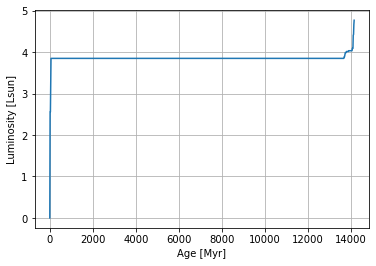

In [166]:
plt.plot(timestamps, cumulative_luminosity)
plt.gca().set_xlabel('Age [Myr]')
plt.gca().set_ylabel('Luminosity [Lsun]')
plt.grid()

In [171]:
fig = px.line(x = timestamps, y = cumulative_luminosity)
fig.update_xaxes(title="Time [Myr]")
fig.update_yaxes(title="Luminosity [Lsun]")